# Building Network

In this notebook the network according to retweets/mentions/replys will be build and visualized

In [27]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as md

from itertools import count
from collections import Counter
import matplotlib

import networkx as nx

from fa2 import ForceAtlas2

In [2]:
import sys

def parse(f,chunksize = 100000, cols = None, test_bool = False, dtype = None):
    lines = 9041*1000
    for i,gm_chunk in enumerate(pd.read_csv("../ira_tweets_csv_hashed.csv",chunksize = chunksize, usecols = cols, dtype = dtype)):
        f(gm_chunk)
        if test_bool:
            print('Done')
            break
        j = i*chunksize/lines
        sys.stdout.write('\r')
        # the exact output you're looking for:
        bar_int = int(j*20+1)
        sys.stdout.write("[%-20s] %d%%" % ('='*bar_int, int(j*100+1)))
        sys.stdout.flush()

In [4]:
global df_test
def f(chunk):
    global df_test
    df_test = chunk

parse(f, 2, test_bool = True)

df_test[:1].to_string()

Done


'              tweetid                                             userid                                  user_display_name                                   user_screen_name user_reported_location user_profile_description  user_profile_url  follower_count  following_count account_creation_date account_language tweet_language                                         tweet_text        tweet_time tweet_client_name  in_reply_to_tweetid  in_reply_to_userid  quoted_tweet_tweetid  is_retweet  retweet_userid  retweet_tweetid  latitude  longitude  quote_count  reply_count  like_count  retweet_count hashtags                                          urls user_mentions  poll_choices\n0  877919995476496385  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...  249064136b1c5cb00a705316ab73dd9b53785748ab757f...         Москва, Россия    Я примерный семьянин!               NaN             132              120            2013-12-07               ru      

In [7]:
global G
G = nx.Graph()
hashtag_set = set()
def f(chunk):
    for uid, fc, lang in zip(chunk['userid'], chunk['follower_count'], chunk['account_language']):
        G.add_node(uid, lang = lang)
            
parse(f, 40000,cols = ['userid', 'follower_count', 'account_language'], test_bool = False)    

[====================] 100%

In [11]:
global nset
nset = set(G.nodes())

In [13]:
cols = ["in_reply_to_userid", "userid", 'retweet_userid', 'user_mentions']

global id_rep_id
id_rep_id = defaultdict(int)
id_retw_id = defaultdict(int)
id_ment_id = defaultdict(int)


def f(chunk):
    #rt_ids_set = rt_ids_set.union(chunk['retweet_tweetid'])
    for uid, rpid,rtwid,mentids in zip(chunk['userid'], chunk['in_reply_to_userid'], chunk['retweet_userid'], chunk['user_mentions']):
        if rpid in nset and uid in nset:
            id_rep_id[(uid, rpid)] += 1
        if rtwid in nset and uid in nset:
            id_retw_id[(uid, rtwid)] += 1
        if mentids == mentids:
            mentids = mentids.replace("[", '').replace("]", '').split(',')
            for mentid in mentids:
                if uid in nset and mentid in nset:
                    id_ment_id[(uid,mentid)] += 1            

parse(f, 100000, cols = cols, test_bool = False)   

[====================] 100%

In [14]:
total_edge_dict = defaultdict(int)

for e,w in id_retw_id.items():
    total_edge_dict[e[0],e[1]] += w
    #G.add_edge(e[0], e[1], weight = w)
for e,w in id_rep_id.items():
    #G.add_edge(e[0], e[1], weight = w)
    total_edge_dict[e[0],e[1]] += w
for e,w in id_ment_id.items(): 
    total_edge_dict[e[0],e[1]] += w
    #G.add_edge(e[0], e[1], weight = w)

In [15]:
for e,w in total_edge_dict.items():
    G.add_edge(e[0], e[1], weight = w)

In [16]:
comp_G = list(nx.connected_component_subgraphs(G))

In [24]:
sorted([len(c.nodes()) for c in comp_G])[:-20:-1]

[2648, 12, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]

In [25]:
H = comp_G[0]
pos = nx.spring_layout(H.to_undirected())

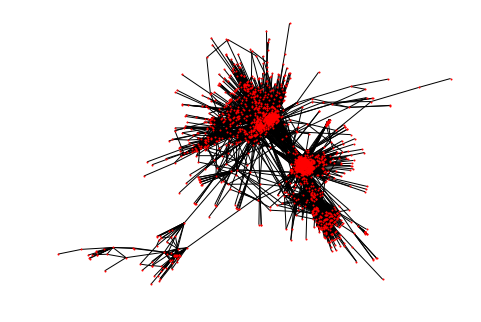

In [26]:
nx.draw(H, pos = pos, node_size = 1)

In [30]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence= 0.5,

                          # Performance
                          jitterTolerance=1., # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.2,

                          # Tuning
                          scalingRatio=2.,
                          strongGravityMode=False,
                          gravity=1,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(H.to_undirected(), pos=None, iterations = 100)

100%|██████████| 200/200 [01:45<00:00,  2.08it/s]

BarnesHut Approximation  took  7.57  seconds
Repulsion forces  took  87.32  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  8.79  seconds
AdjustSpeedAndApplyForces step  took  0.39  seconds


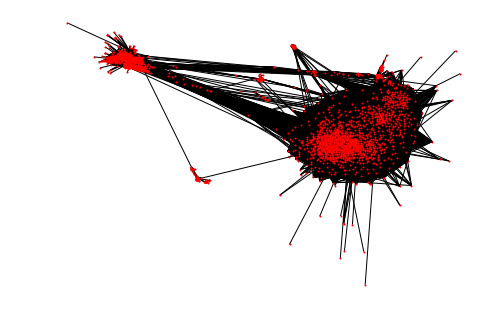

In [31]:
nx.draw(H, pos = positions, node_size = 1)